# Perform clustering (hierarchical,K means clustering and DBSCAN) for the airlines data to obtain optimum number of clusters. Draw the inferences from the clusters obtained.


## Import necessary libraries

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import numpy as np
import pandas as pd

import scipy.cluster.hierarchy as sch # Hierarchical clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.decomposition import PCA # Reduce dimensions of dataset for plots.
from sklearn.neighbors import NearestNeighbors # To find epsilon for DBSCAN

from sklearn.preprocessing import StandardScaler # Standardiztion before clustering

import matplotlib.pyplot as plt
import plotly.express as px

from kneed import KneeLocator # To find elbow point for DBSCAN.


In [39]:
# Matplotlib configurations

# Display interactive plots. Used this since convenient for displaying plots in github.
# %matplotlib notebook
%matplotlib notebook
# Font and figure size:
# Ref: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data

In [40]:
airlines_df = pd.read_excel('EastWestAirlines.xlsx', sheet_name='data')

In [41]:
airlines_df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [42]:
airlines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


## Observations:
- Data contains 3999 records, 11 features, and 1 target. Since clustering is used for unsupervised learning, we split the features from the target.
- Data does not have any null values.
- All features are recorded with correct datatypes.
- ID# is a dummy column and can be dropped for clustering analysis.

## Data preprocessing

In [43]:
airlines_df1 = airlines_df.copy()

In [44]:
airlines_df1.columns

Index(['ID#', 'Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12',
       'Days_since_enroll', 'Award?'],
      dtype='object')

In [45]:
# Standardizing the numeric features.
scaler = StandardScaler()
airlines_df_sc = scaler.fit_transform(airlines_df1.iloc[:, 1:-1])

In [46]:
np.shape(airlines_df_sc)

(3999, 10)

## 1. Hierarchical clustering 

<IPython.core.display.Javascript object>


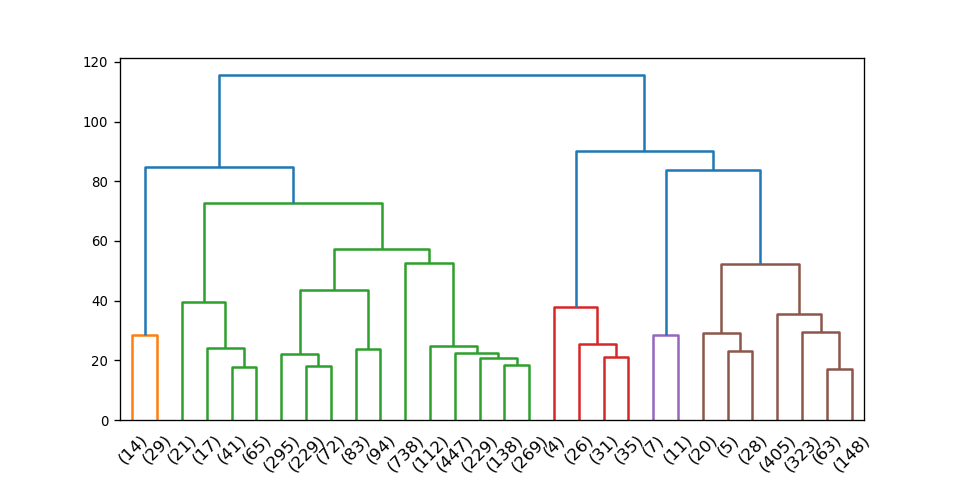

In [47]:
# plotting dendrogram to visualize the clusters.
fig, ax = plt.subplots(figsize=(8,4))
# Setting to truncate the dendrogram: The last p non-singleton clusters formed in the linkage.
ax = sch.dendrogram(sch.linkage(airlines_df_sc, method='ward'),truncate_mode='lastp')

**Note:**  We "cut the dendrogram tree with a horizontal line at a height where the line can traverse the maximum distance up and down without intersecting the merging point."
(ref:https://www.kdnuggets.com/2019/09/hierarchical-clustering.html)

## Observations:
- If we choose the treshold line is at 65 (euclidean distance) we can make 6 different clusters

In [48]:
n_clus = 6# By inspecting the dendrogram and cutting it at a threshold of ~ 5.8.

hc = AgglomerativeClustering(n_clusters=n_clus, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(airlines_df_sc)

In [49]:
airlines_df_hc = pd.concat([airlines_df, pd.Series(y_hc, name='clusters_hc')], axis=1)

In [50]:
airlines_df_hc.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,clusters_hc
0,1,28143,0,1,1,1,174,1,0,0,7000,0,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,1


In [51]:
# Plotting the results
def cluster_visualization(df_sc, labels): # label = y_hc
    #ref:https://www.askpython.com/python/examples/plot-k-means-clusters-python
    # PCA -> N-D to 2D for scatterplot.
    pca = PCA(2)
    df_pca = pca.fit_transform(df_sc)
    u_labels = np.unique(labels)
    
    # Plotting
    fig, ax = plt.subplots()
    for i in u_labels:
        ax.scatter(df_pca[labels == i, 0], df_pca[labels == i, 1], label = i)

    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


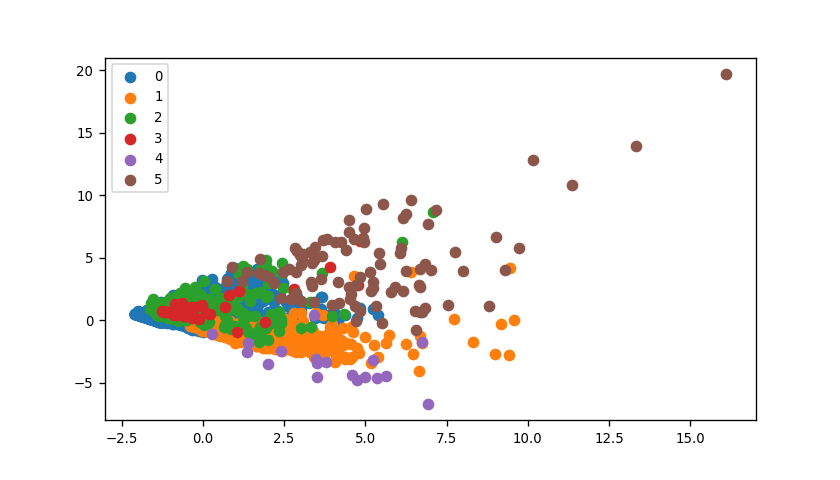

In [52]:
cluster_visualization(airlines_df_sc, y_hc)

## Observations:
- Ward method is able to cluster/ categorize the data better. It is able to make 6 clusters fairly well despite the overlaps

## KMeans clustering

<IPython.core.display.Javascript object>


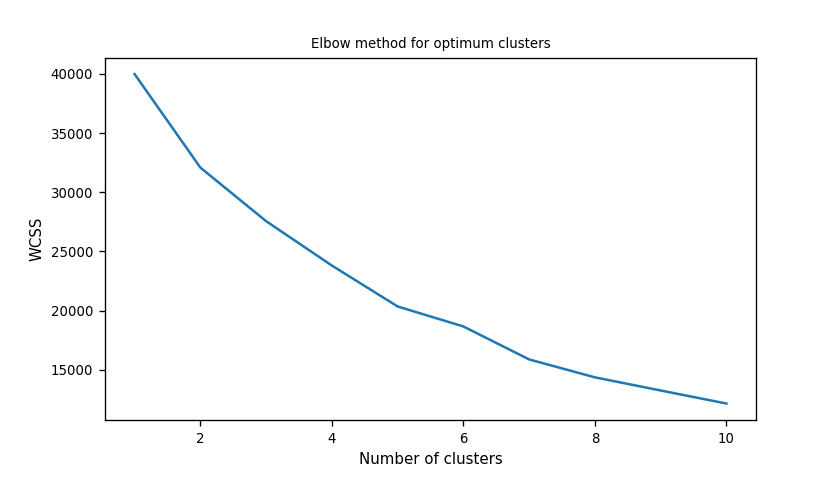

In [53]:
# Finding the optimum number of clusters
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(airlines_df_sc)
    wcss.append(kmeans.inertia_) # Calculate WCSS
    
fig, ax = plt.subplots()
ax.plot(range(1,11),wcss)
ax.set_title('Elbow method for optimum clusters')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('WCSS')
plt.show()

## Observations
- From the elbow curve we see that at 5 or 6 clusters, the rate of decrease in WCSS is becoming gradual. With a lttle trial and error checking the scatterplots for clear distinction between clusters, we see that, with  6 clusters the divisions are very clear compared to other options.

In [54]:
# Build cluster algorithm.
num_clusters = 6 # Chosen by trial and error b/w (5,6,7)
clusters_new = KMeans(num_clusters, random_state=42)
clusters_new.fit(airlines_df_sc)

KMeans(n_clusters=6, random_state=42)

In [55]:
labels_km = clusters_new.labels_
# Assign clusters to the dataset.
airlines_df_km = pd.concat([airlines_df, pd.Series(labels_km, name='clusters_km')], axis=1)

In [56]:
airlines_df_km.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,clusters_km
0,1,28143,0,1,1,1,174,1,0,0,7000,0,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,2


<IPython.core.display.Javascript object>


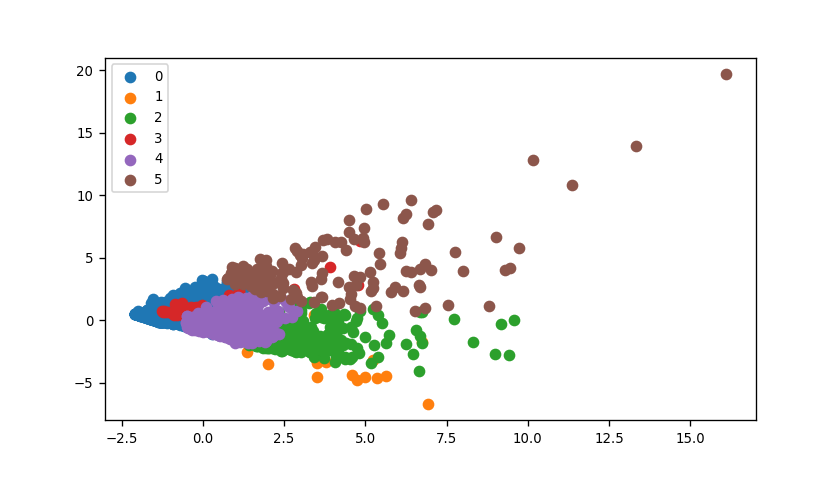

In [57]:
cluster_visualization(airlines_df_sc, labels_km)

## Observations:
- Kmeans is able to grop the members better.

## DBSCAN Clustering

<IPython.core.display.Javascript object>


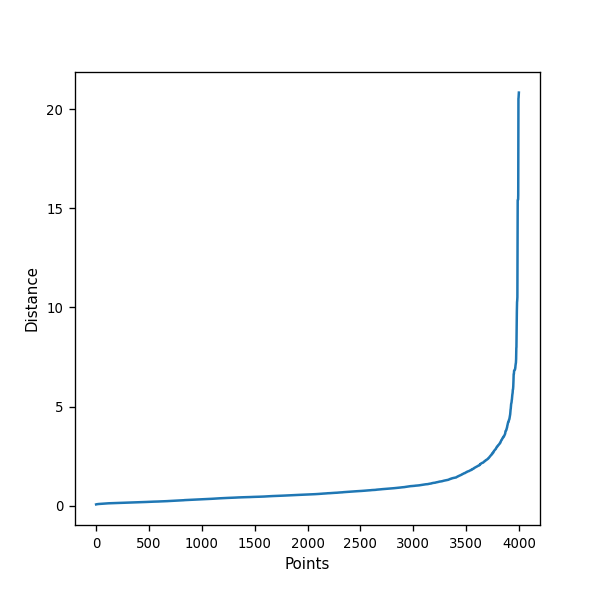

In [58]:
# n_neighbours is same as MinPts or min_samples. As a thumb rule it is
# taken as 2* (no of dimensions or features) in the dataset.
# Ref:https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

# Epsilon value is found by calculatind the average distance between each point and
# its nearest neighbours.
# Ref:https://machinelearningknowledge.ai/tutorial-for-dbscan-clustering-in-python-sklearn/
# Ref: https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan
# Ref: https://link.springer.com/article/10.1023/A:1009745219419

neighbors = 22 # 2*11 dimensions
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(airlines_df_sc)
distances, indices = nbrs.kneighbors(airlines_df_sc)
distances = np.sort(distances[:,neighbors-1], axis=0)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(distances)
ax.set_xlabel("Points")
ax.set_ylabel("Distance")
plt.show()

<IPython.core.display.Javascript object>


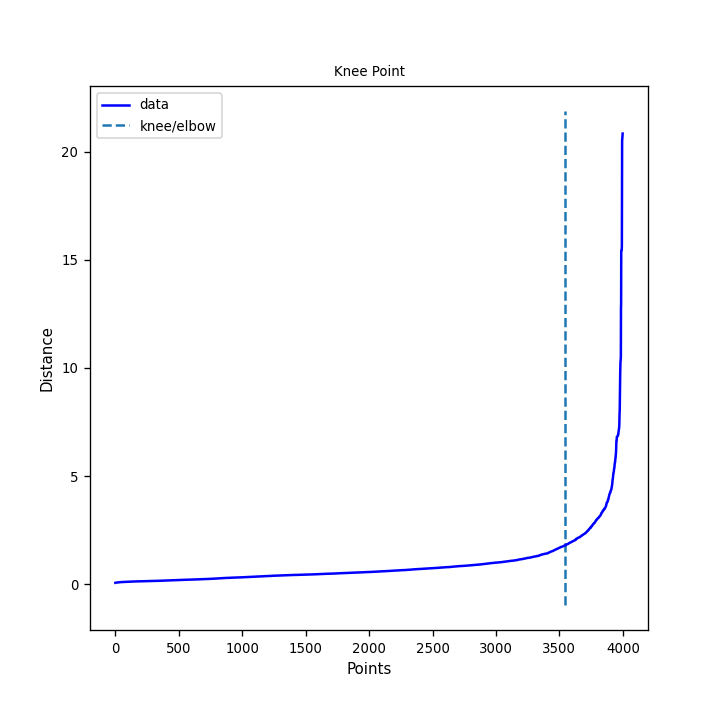

Optimum value for epsilon =  1.8053851777743328


In [59]:
# Ref: https://github.com/arvkevi/kneed
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print("Optimum value for epsilon = ",distances[knee.knee])

In [60]:
# Optimum value for epsilon.
epsillon = np.round(distances[knee.knee],3)

In [61]:
# DBSCAN algorithm for classification.
dbscan = DBSCAN(eps=epsillon, min_samples=22)
# Note: If your data has more than 2 dimensions, choose min_samples = 2*dim, 
# where dim= the dimensions of your data set (Sander et al., 1998)
dbscan.fit(airlines_df_sc)

DBSCAN(eps=1.805, min_samples=22)

In [62]:
#Noisy samples are given the label -1.
labels_db = dbscan.labels_

In [63]:
# Assign clusters to the dataset.
airlines_df_db = pd.concat([airlines_df, pd.Series(labels_db, name='clusters_db')], axis=1)

In [64]:
airlines_df_db.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,clusters_db
0,1,28143,0,1,1,1,174,1,0,0,7000,0,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0


<IPython.core.display.Javascript object>


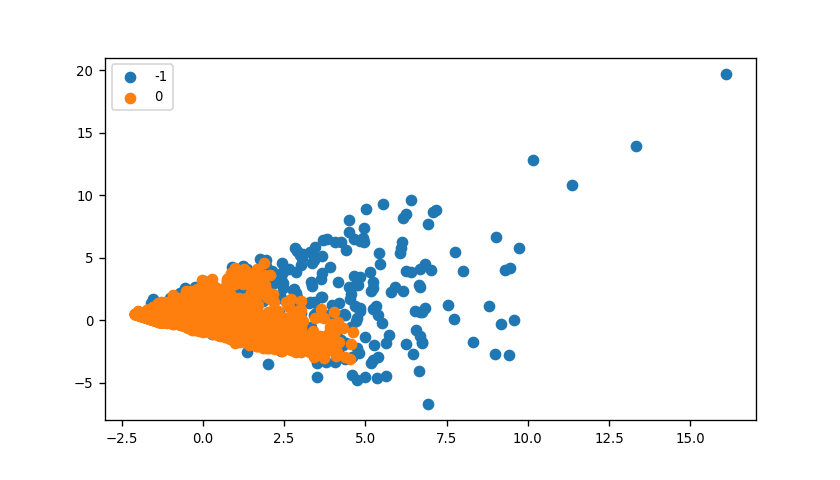

In [65]:
cluster_visualization(airlines_df_sc, labels_db)

## Observations:
DBSCAN is only able to make 2 clusters, rather only one cluster and the rest are outliers.Thus it is not a good fit for this problem.

In [66]:
# Extracting the groups based on Labels for KMeans clustering:
cluster_labels = airlines_df_km['clusters_km'].unique()

groups = [] # List to contain different clusters.
for cluster in cluster_labels:
    groups.append(airlines_df_km[airlines_df_km['clusters_km']==cluster])

In [67]:
groups[0].head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,clusters_km
0,1,28143,0,1,1,1,174,1,0,0,7000,0,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,0
5,6,16420,0,1,1,1,0,0,0,0,6942,0,0


In [68]:
groups[1].head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,clusters_km
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,2
11,12,96522,0,5,1,1,61105,19,0,0,6924,1,2
20,21,120576,0,5,1,1,58831,23,250,2,6896,1,2
32,33,276571,0,4,1,1,42044,23,0,0,7872,0,2
35,36,123759,0,4,1,1,50572,23,2500,5,7865,1,2


In [69]:
groups[2].head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,clusters_km
6,7,84914,0,3,1,1,27482,25,0,0,6994,0,4
9,10,104860,0,3,1,1,28426,28,1150,3,6931,1,4
10,11,40091,0,2,1,1,7278,10,0,0,6959,0,4
12,13,43382,0,2,1,1,11150,20,0,0,6924,0,4
15,16,28495,0,4,1,1,49442,15,0,0,6912,1,4


In [70]:
groups[3].head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,clusters_km
8,9,443003,0,3,2,1,1753,43,3850,12,6948,1,3
198,202,8669,0,1,3,1,11397,16,0,0,7486,1,3
226,230,117329,0,1,2,1,6448,11,0,0,7416,1,3
381,386,167670,0,1,3,1,15907,13,0,0,6994,0,3
392,398,11189,0,1,2,1,9044,20,0,0,8296,1,3


In [71]:
groups[4].head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,clusters_km
22,23,20584,0,1,1,1,3450,11,3450,11,6884,0,5
42,43,60313,0,1,1,1,10000,26,3250,9,7829,1,5
50,51,108137,0,1,1,1,6368,5,6368,5,6844,0,5
65,66,53914,0,3,1,1,33767,45,5550,29,6826,1,5
94,97,185549,0,5,1,1,110859,39,2950,16,6778,1,5


In [72]:
groups[5].head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,clusters_km
106,109,96627,1182,1,1,3,49059,26,2300,9,6738,1,1
384,389,28193,0,5,1,4,103456,32,0,0,6980,1,1
850,861,25629,0,4,1,5,107308,36,600,2,5966,1,1
904,915,15835,0,2,1,5,112171,16,0,0,5825,1,1
1036,1047,154664,0,4,1,3,73881,33,0,0,5769,0,1


## Conclusions:
- Three different clustering methods were implemented on the airlines dataset.
- Based on the clusters formed, KMeans clustering algorithm is able to make somewhat distinct groups for the airlines dataset. We can thus divide the customer into six groups and provide services to them appropriately.